In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix, csc_matrix
from sklearn.metrics import mean_squared_error
from math import sqrt

# Coordinate descent function

In [2]:
def coordinate_descent(X, y, N, d, lam, initial_weights, initial_bias):
    # Setting up initial weights
    w = initial_weights
    
    # Setting up initial bias
    bias = initial_bias
    b = csc_matrix(bias * np.ones(shape=(N, 1)))
    
    # Setting up values of ak
    a = np.ones(shape=(d, 1))
    for i in range(d):
        temp = X.getrow(i)
        a[i] = 2 * temp.multiply(temp).sum()

    # Creating ck for k from 1 to d
    c = np.ones(shape=(d, 1))
    
    old_obj = 0

    while True:

        # calculating r
        xtw = X.transpose() * w
        addition = xtw + b
        r = y - addition

        # updating bias
        bias += (r.sum() / float(N))
        b = csc_matrix(bias * np.ones(shape=(N, 1)))

        # updating r
        constant = r.sum() / float(N)
        r = r - csc_matrix(constant * np.ones(shape=(N, 1)))

        # k loop
        for k in range(d):
            
            # updating c
            kth_row = X.getrow(k)
            cols_nonzero = kth_row.nonzero()[1]
            
            summation = 0
            
            for i in cols_nonzero:
                summation += (kth_row[0, i] * (r[i, 0] + (w[k, 0] * kth_row[0, i])))
            c[k] = 2 * summation

            # updating w
            wk_old = w[k]

            if c[k] < (-1) * lam:
                w[k] = float(c[k] + lam) / float(a[k])
            elif c[k] > lam:
                w[k] = float(c[k] - lam) / float(a[k])
            else:
                w[k] = 0

            # updating r
            # take transpose of kth row of X (corresponds to kth dimension), multiply it by (w_old - w_new)
            r = r + ((wk_old - w[k]).toarray()[0][0] * kth_row.transpose())
        
        objective = r.multiply(r).sum() + (lam * abs(w).sum())
        print(objective)
        
        if abs(objective - old_obj) < 10:
            break
        
        old_obj = objective
        
    return w, bias

# Wine data

## Training set

In [3]:
x_read = pd.read_csv("./trainData.txt", delimiter=" ", header=None)
y_read = pd.read_csv("./trainLabels.txt", header=None)

In [4]:
row = []
col = []
data = []

for index, r in x_read.iterrows():
    col.append(r[0] - 1)
    row.append(r[1] - 1)
    data.append(r[2])

rows = np.array(row)
cols = np.array(col)
data_points = np.array(data)

X = coo_matrix((data, (row, col)))
X = csc_matrix(X)

y = csc_matrix(y_read)

d = X.shape[0]
N = X.shape[1]

## Validation set

In [5]:
x_val_read = pd.read_csv("./valData.txt", delimiter=" ", header=None)
y_val_read = pd.read_csv("./valLabels.txt", header=None)

In [6]:
row = []
col = []
data = []

for index, r in x_val_read.iterrows():
    col.append(r[0] - 1)
    row.append(r[1] - 1)
    data.append(r[2])

rows = np.array(row)
cols = np.array(col)
data_points = np.array(data)

X_val = coo_matrix((data, (row, col)))
X_val = csc_matrix(X_val)

y_val = csc_matrix(y_val_read)

d_val = X_val.shape[0]
N_val = X_val.shape[1]

## Calculating lambda max and setting initial values

In [15]:
const = y.sum() / float(N)
temp = y - coo_matrix(const * np.ones(shape=(N, 1)))
mult = X * temp
lammax = 2 * np.linalg.norm(mult.toarray(), np.inf)

In [16]:
l = []
w = []
b = []
t = []
v = []
n = []

## Regularization path

In [17]:
bias = 1
weights = csc_matrix(np.ones(shape=(d, 1)))
lam = lammax

while True:
    
    print "lambda = ", lam
    print "objective function values:"
    
    # Call coordinate descent
    weights, bias = coordinate_descent(X, y, N, d, lam, weights, bias)
    
    print ""
    
    # Append l, w, b, t, v, n to respective arrays
    y_pred = (X.transpose() * weights) + (bias * csc_matrix(np.ones(shape=(N, 1))))
    train_error = sqrt(mean_squared_error(y.toarray(), y_pred.toarray()))
    
    y_val_pred = (X_val.transpose() * weights) + (bias * csc_matrix(np.ones(shape=(N_val, 1))))
    validation_error = sqrt(mean_squared_error(y_val.toarray(), y_val_pred.toarray()))
    
    l.append(lam)
    w.append(np.transpose(weights.toarray())[0])
    b.append(bias)
    t.append(train_error)
    v.append(validation_error)
    n.append(weights.count_nonzero())
    
    print "Validation errors: ", v
    
    if len(v) > 1:
        if v[-1] >  v[-2]:
            break
    
    lam = lam / 2

lambda =  1271.869651
objective function values:
230851.284744
169608.56522
127424.11822
116030.556599
115339.9759
115339.9759

Validation errors:  [3.3895861945081145]
lambda =  635.9348255
objective function values:
113464.97052
113351.724815
113268.054226
113230.355473
113218.396063
113214.759373

Validation errors:  [3.3895861945081145, 3.2412400776788184]
lambda =  317.96741275
objective function values:
104738.684741
104551.489754
104543.97238

Validation errors:  [3.3895861945081145, 3.2412400776788184, 3.0015160579206355]
lambda =  158.983706375
objective function values:
93427.2510091
93157.6156333
93126.7153739
93101.1326074
93080.6236026
93066.3107944
93057.5419756

Validation errors:  [3.3895861945081145, 3.2412400776788184, 3.0015160579206355, 2.785780650082134]
lambda =  79.4918531875
objective function values:
81062.1062604
80612.1672541
80552.4043291
80513.3620368
80482.4057553
80456.1641073
80433.9610165
80415.5741849
80401.1665399
80390.4104958
80381.6312596

Validati

## Results

### Lambda

In [18]:
l

[1271.8696510000054,
 635.93482550000272,
 317.96741275000136,
 158.98370637500068,
 79.49185318750034,
 39.74592659375017,
 19.872963296875085,
 9.9364816484375424,
 4.9682408242187712,
 2.4841204121093856,
 1.2420602060546928]

### Weights

In [19]:
w

[array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.        ,  1.00978412,  0.        , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.        ,  2.28668148,  1.70181785, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.        ,  2.85398928,  3.49246666, ...,  0.        ,
         0.00405587,  0.35251763]),
 array([ 0.        ,  3.40785916,  4.82490395, ..., -0.38041382,
         0.60224647,  1.21856919])]

### Biases

In [20]:
b

[87.932900000000004,
 88.170626516171126,
 88.111864188035582,
 87.904740384626905,
 87.475222182681605,
 86.882270242346991,
 86.165086438463661,
 85.398733834260668,
 84.638199943484281,
 84.014588693610975,
 83.647902781819951]

### Training errors

In [21]:
t

[3.396173963447691,
 3.238322144707735,
 2.9879366102450344,
 2.7542809757877276,
 2.4886447243449688,
 2.270484805235794,
 2.077738219989243,
 1.8797392635286654,
 1.7187532695297227,
 1.595002031123992,
 1.5241736705359035]

### Validation errors

In [22]:
v

[3.3895861945081145,
 3.2412400776788184,
 3.0015160579206355,
 2.785780650082134,
 2.5429305094707444,
 2.3474344797366755,
 2.1883453070331873,
 2.0538853351627013,
 1.9764444020617309,
 1.9618388378919038,
 1.9924953257516271]

### Count of nonzero weights

In [23]:
n

[0, 6, 17, 46, 112, 225, 403, 716, 1178, 1784, 2254]

## Storing the results

In [29]:
w_file = pd.DataFrame(w)

In [30]:
w_file.to_csv("./weights.csv")

In [31]:
l_file = pd.DataFrame(l)

In [32]:
l_file.to_csv("./lambdas.csv")

In [33]:
b_file = pd.DataFrame(b)

In [34]:
b_file.to_csv("./biases.csv")

In [35]:
t_file = pd.DataFrame(t)

In [36]:
t_file.to_csv("./training_errors.csv")

In [37]:
v_file = pd.DataFrame(v)

In [38]:
v_file.to_csv("./validation_errors.csv")

In [39]:
n_file = pd.DataFrame(n)

In [40]:
n_file.to_csv("./nonzero_counts.csv")

## Plots

### RMSE vs lambda has been represented in a plot of RMSE vs iteration number, where:
### lower iteration number (towards left of X-axis) indicates higher lambda
### higher iteration number (towards right of X-axis) indicates lower lambda

In [21]:
import pandas as pd
t_read = pd.read_csv("./training_errors.csv")
v_read = pd.read_csv("./validation_errors.csv")

In [25]:
t = list(t_read['0'])

In [31]:
v = list(v_read['0'])

### Continuous plot

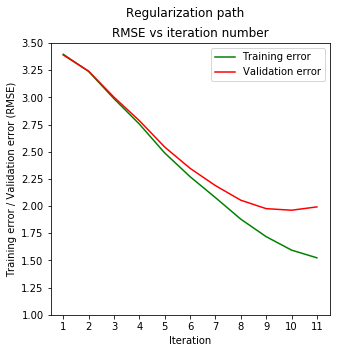

In [34]:
plot_iterations = [1,2,3,4,5,6,7,8,9,10,11]
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(plot_iterations, t,'g', markersize=6)
plt.plot(plot_iterations, v,'r', markersize=6)
plt.legend(["Training error", "Validation error"])
plt.xticks(plot_iterations)
y_ticks = [i for i in np.arange(1, 3.75, 0.25)]
plt.yticks(y_ticks)
plt.xlabel("Iteration")
plt.ylabel("Training error / Validation error (RMSE)")
plt.suptitle("Regularization path")
plt.title("RMSE vs iteration number")
plt.show()

### Discrete plot

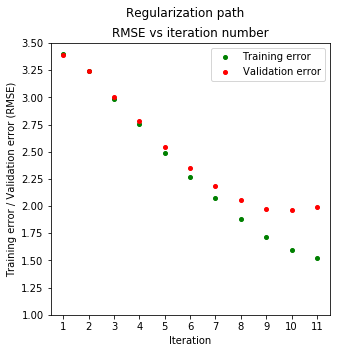

In [38]:
plot_iterations = [1,2,3,4,5,6,7,8,9,10,11]
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(plot_iterations, t,'go', markersize=4)
plt.plot(plot_iterations, v,'ro', markersize=4)
plt.legend(["Training error", "Validation error"])
plt.xticks(plot_iterations)
y_ticks = [i for i in np.arange(1, 3.75, 0.25)]
plt.yticks(y_ticks)
plt.xlabel("Iteration")
plt.ylabel("Training error / Validation error (RMSE)")
plt.suptitle("Regularization path")
plt.title("RMSE vs iteration number")
plt.show()

#### At the 10th iteration, we get the minimum value of validation error.

In [3]:
import pandas as pd
non_zeroes_read = pd.read_csv("./nonzero_counts.csv")

In [9]:
non_zero_values = list(non_zeroes_read['0'])

### Continuous plot

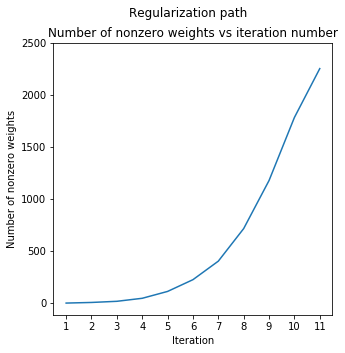

In [20]:
plot_iterations = [1,2,3,4,5,6,7,8,9,10,11]
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,5))
plt.plot(plot_iterations, non_zero_values) #,'go', markersize=4)
plt.xticks(plot_iterations)
y_ticks = [i for i in np.arange(0, 3000, 500)]
plt.yticks(y_ticks)
plt.xlabel("Iteration")
plt.ylabel("Number of nonzero weights")
plt.suptitle("Regularization path")
plt.title("Number of nonzero weights vs iteration number")
plt.show()

### Discrete plot

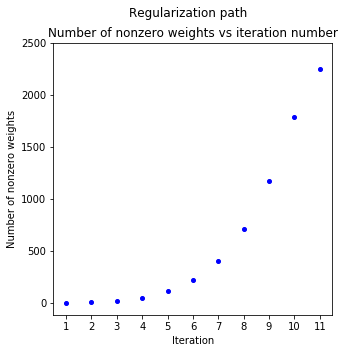

In [40]:
plot_iterations = [1,2,3,4,5,6,7,8,9,10,11]
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,5))
plt.plot(plot_iterations, non_zero_values,'bo', markersize=4)
plt.xticks(plot_iterations)
y_ticks = [i for i in np.arange(0, 3000, 500)]
plt.yticks(y_ticks)
plt.xlabel("Iteration")
plt.ylabel("Number of nonzero weights")
plt.suptitle("Regularization path")
plt.title("Number of nonzero weights vs iteration number")
plt.show()

# Model

In [47]:
import pandas as pd
l_read = pd.read_csv("./lambdas.csv")
v_read = pd.read_csv("./validation_errors.csv")

In [50]:
l = list(l_read['0'])
v = list(v_read['0'])

In [51]:
l

[1271.869651,
 635.93482549999999,
 317.96741274999999,
 158.983706375,
 79.491853187499999,
 39.7459265938,
 19.8729632969,
 9.9364816484399991,
 4.9682408242199996,
 2.4841204121099998,
 1.2420602060500001]

In [52]:
v

[3.3895861945099997,
 3.2412400776800001,
 3.00151605792,
 2.78578065008,
 2.5429305094700001,
 2.34743447974,
 2.1883453070299996,
 2.0538853351599999,
 1.9764444020599996,
 1.96183883789,
 1.99249532575]

### The lambda that achieves the best performance on the validation set is 2.4841204121099998

In [53]:
w_read = pd.read_csv("./weights.csv")

In [60]:
np_w_read = w_read.as_matrix()

In [88]:
best_weights = list(np_w_read[9])

In [89]:
best_weights = best_weights[1:]

## Top 10 features

In [90]:
sorted_weights = sorted(best_weights, reverse=True)
top_10 = sorted_weights[:10]

In [91]:
top_10

[10.527860370399999,
 10.259023345399999,
 9.6656205507600017,
 9.4841935561700002,
 8.8452248929399993,
 8.6661815008200005,
 8.3175169114699994,
 8.2983356995699999,
 8.2895126709200007,
 8.0127295424000007]

In [92]:
top_10_features = []
for elem in top_10:
    top_10_features.append(best_weights.index(elem) + 1)

In [93]:
top_10_features

[974, 359, 2545, 993, 1836, 812, 1273, 1818, 1413, 934]

#### These feature numbers correspond to the following features (from highest to lowest weights):
1. spearmint
2. lemon lime flavors
3. big
4. lifesaver
5. lemony
6. ageability
7. sweet black
8. nearly
9. truly
10. acidity provides

## Bottom 10 features

In [94]:
sorted_weights = sorted(best_weights)
bottom_10 = sorted_weights[:10]

In [95]:
bottom_10

[-9.6023949099500001,
 -6.8671123986300007,
 -6.44827431561,
 -5.9622432139799999,
 -5.7678789757899995,
 -5.5684606965699999,
 -5.3839409592499994,
 -5.3002934220199993,
 -5.2458482765800003,
 -5.1185656563499995]

In [96]:
bottom_10_features = []
for elem in bottom_10:
    bottom_10_features.append(best_weights.index(elem) + 1)

In [97]:
bottom_10_features

[741, 2586, 2628, 1487, 2043, 2564, 2850, 393, 1234, 440]

#### These feature numbers correspond to the following features (from lowest to highest weights):
1. earns
2. cherry berry
3. high
4. soft
5. sparkler
6. cuts
7. brightened
8. semillon
9. black
10. liqueur

# Test set

In [68]:
x_test_read = pd.read_csv("./testData.txt", delimiter=" ", header=None)

In [136]:
row = []
col = []
data = []

for index, r in x_test_read.iterrows():
    col.append(r[0] - 1)
    row.append(r[1] - 1)
    data.append(r[2])

rows = np.array(row)
cols = np.array(col)
data_points = np.array(data)

X_test = coo_matrix((data, (row, col)))
X_test = csc_matrix(X_test)

d_test = X_test.shape[0]
N_test = X_test.shape[1]

In [137]:
X_test

<3000x20534 sparse matrix of type '<type 'numpy.float64'>'
	with 506990 stored elements in Compressed Sparse Column format>

In [139]:
weights_best = csc_matrix(w[-2]).transpose()

In [140]:
weights_best

<3000x1 sparse matrix of type '<type 'numpy.float64'>'
	with 1784 stored elements in Compressed Sparse Row format>

In [141]:
bias_best = b[-2]

In [142]:
bias_best

84.014588693610975

In [143]:
X_test

<3000x20534 sparse matrix of type '<type 'numpy.float64'>'
	with 506990 stored elements in Compressed Sparse Column format>

In [144]:
y_test = (X_test.transpose() * weights_best) + (bias_best * csc_matrix(np.ones(shape=(N_test, 1))))

In [198]:
y_test

<20534x1 sparse matrix of type '<type 'numpy.float64'>'
	with 20534 stored elements in Compressed Sparse Row format>

In [219]:
result = pd.DataFrame(y_test.toarray())

In [220]:
result.columns = ['Points']

In [221]:
indices = [i for i in range(1, len(result) + 1)]

In [222]:
indices[-1]

20534

In [223]:
result['ID'] = pd.Series(indices)

In [224]:
result_cols = ['ID', 'Points']

In [225]:
result = result[result_cols]

In [226]:
result

,ID,Points
0,1,91.427697
1,2,82.391263
2,3,89.582660
3,4,88.143209
4,5,82.688011
5,6,87.689651
6,7,87.567576
7,8,87.811686
8,9,90.039876
9,10,91.031498


In [227]:
result.to_csv("./predTestLabels.csv", index=False)

### The RMSE is 1.95783.